Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Sunsun Kasajoo"
ID = "st122283"

---

# Lab 12: Gaussian Mixture Models (GMMs)

Today we continue with unsupervised learning. One model that's more sophisticated than $k$-means is the Gaussian Mixture Model (GMM).

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [4]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [5]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.58015073 0.22384928 0.19599999]
[0.2, 0.2, 0.6]
0.00014199790380354293


In [6]:
print(Mu)
print(np.array(means_gt).T)

[[10.05294994 10.2167471   1.0192569 ]
 [ 9.86773705  0.88913405 10.11148374]]
[[ 1 10 10]
 [10  1 10]]


In [7]:
print(Sigma)
print(sigmas_gt)

[[[ 0.95677108 -0.0328217 ]
  [-0.0328217   3.78130209]]

 [[ 3.95188325  0.22005314]
  [ 0.22005314  1.04358406]]

 [[ 1.10617006  0.0213828 ]
  [ 0.0213828   0.69941532]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise (not graded, for practice)

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning of the experiment. Report your results and briefly discuss here.

Next, we continue to find outliers:

The estimated Phi was [0.20999999 0.19969067 0.59030934] which is close to the ground truth values of [0.2, 0.2, 0.6]. 

The estimated means were $\mathbf{\mu}_{1}=\begin{bmatrix} 0.80616335 \\ 10.02275277 \\\end{bmatrix}$, $\mathbf{\mu}_{2}=\begin{bmatrix} 10.33766036  \\ 0.8575927 \\\end{bmatrix}$, $\mathbf{\mu}_{3}=\begin{bmatrix} 10.03837514 \\ 10.18356989 \\\end{bmatrix}$

which are also close to the ground truth values of $\mathbf{\mu}_{1}=\begin{bmatrix} 1 \\ 10 \\\end{bmatrix}$, $\mathbf{\mu}_{2}=\begin{bmatrix} 10  \\ 1 \\\end{bmatrix}$, $\mathbf{\mu}_{3}=\begin{bmatrix} 10 \\ 10 \\\end{bmatrix}$

The estimated sigmas were $\mathbf{\Sigma_1}=\begin{bmatrix} 1.18687404  & 0.23011822 \\ 0.23011822 & 1.17057606 \\\end{bmatrix}$, $\mathbf{\Sigma_2}=\begin{bmatrix} 4.896009 & 0.14325881 \\ 0.14325881 & 1.23725936 \\\end{bmatrix}$, $\mathbf{\Sigma_3}=\begin{bmatrix} 0.85685937 & -0.05026115 \\ -0.05026115 & 4.25412224 \\\end{bmatrix}$

and the ground truth sigmas were $\mathbf{\Sigma_1}=\begin{bmatrix} 1  & 0 \\ 0 & 1 \\\end{bmatrix}$, $\mathbf{\Sigma_2}=\begin{bmatrix} 4 & 0 \\ 0 & 1 \\\end{bmatrix}$, $\mathbf{\Sigma_3}=\begin{bmatrix} 1 & 0 \\ 0 & 4 \\\end{bmatrix}$

In [8]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

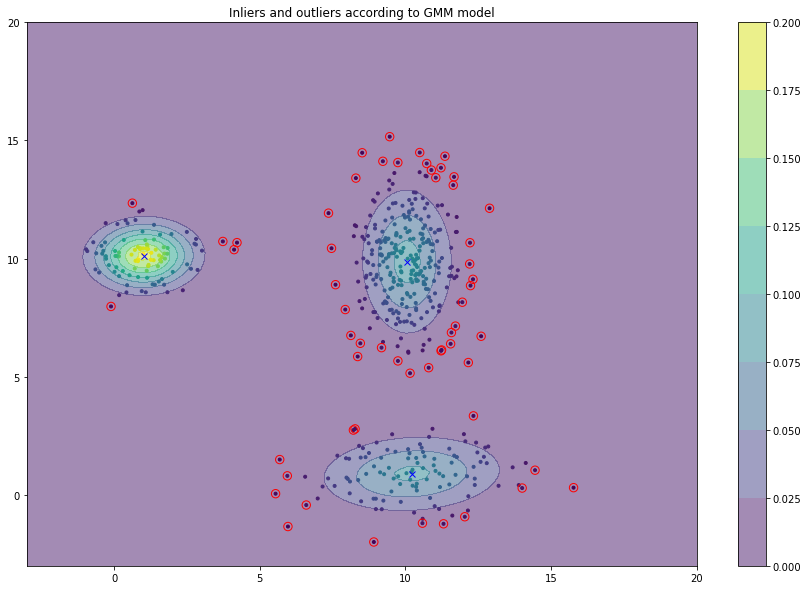

In [9]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, you'll want to understand why and explain.  Next, you'll read about
Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain here.

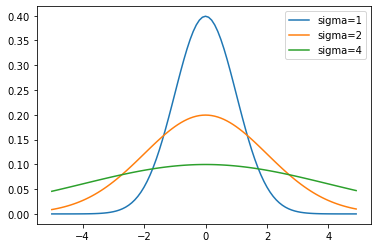

In [10]:
# Plot of 1D gaussian curves
import scipy
from scipy import stats

mean_1 = 0
standard_deviation_1 = 1

mean_2 = 0
standard_deviation_2 = 2

mean_3 = 0
standard_deviation_3 = 4

x_values = np.arange(-5, 5, 0.1)
y_values_1 = scipy.stats.norm(mean_1, standard_deviation_1)
y_values_2 = scipy.stats.norm(mean_2, standard_deviation_2)
y_values_3 = scipy.stats.norm(mean_3, standard_deviation_3)

plt.plot(x_values, y_values_1.pdf(x_values), label='sigma=1')
plt.plot(x_values, y_values_2.pdf(x_values), label='sigma=2')
plt.plot(x_values, y_values_3.pdf(x_values), label='sigma=4')
plt.legend()

From the 1D gaussian plot we can see that as the width increases the height decreases. So as cluster becomes broad(spread increases) more points fall below any probability density function threshold.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis distance (5 points)

Mahalanobis distance is the distance betweena a data point and the centroid of the distribution. It takes into account the correlation in the data. It is a better way to find the outliers.

The formula of Mahalanobis distance is -

$$D_M(\vec{x})=\sqrt{(\vec{x}-\vec{\mu})^T S^{-1} (\vec{x}-\vec{\mu}) }$$

#### Write code to compute Mahalanobis distance between the data and their nearest means (10 points)

In [11]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

(3, 2, 2)
(2, 3)
(500, 2)


outlier (array([  1,   4,  24,  25,  36,  53,  64,  65,  67,  71,  74,  78,  80,
        96, 103, 104, 106, 108, 122, 125, 129, 144, 155, 158, 163, 176,
       194, 225, 247, 264, 279, 289, 299, 303, 316, 317, 320, 323, 325,
       327, 332, 334, 341, 355, 376, 396, 408, 414, 420, 424, 427, 435,
       443, 447, 458, 474, 476, 477, 479, 480, 485, 499]),)


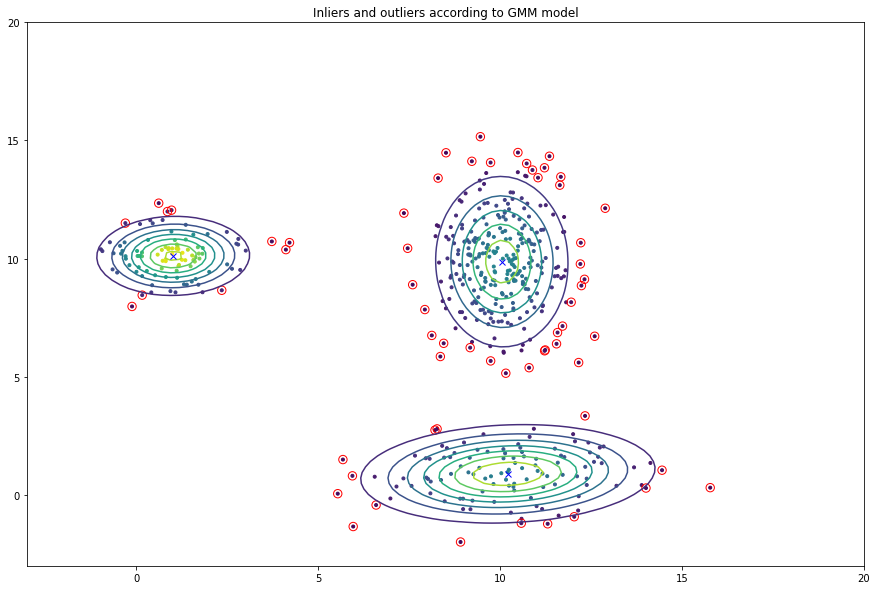

success!


In [12]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation dataset
from last week. We've included the
[Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
file with this lab.

Let's stick to just two dimensions in the dataset:

In [13]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [14]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [15]:
print(Mu)

[[60.67829719 85.65390233 51.1352792 ]
 [19.1904068  82.10974775 53.82751176]]


The first row represents annual income, whereas the second row represents the spending score. These values tend to change in every iteration, so therefore it is difficult to definitively segregate the data into three categories.

In [16]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

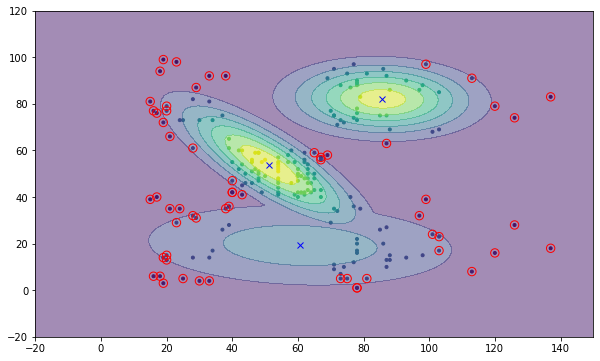

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to the $k$-means method from last week. (20 points)

#### Interpretation of clusters (5 points)

In [18]:
Mu.T

array([[60.67829719, 19.1904068 ],
       [85.65390233, 82.10974775],
       [51.1352792 , 53.82751176]])

Examining the three cluster centers above it can be interpreted as cluster of high income, low expenditure (miser), low income, high expenditure and average income, average expenditure.

#### Run $k$-means and compare results

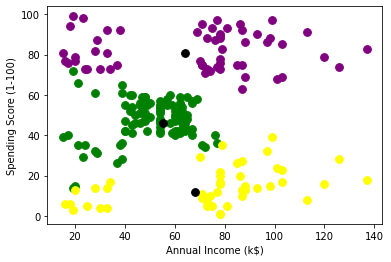

In [19]:
from IPython.display import clear_output
import time
from sklearn.metrics import pairwise_distances_argmin

# 1. Initialize three random cluster centers
# Taking first 3 points as centers
centers = np.array([X[0],X[1],X[2]])
means =  np.zeros((centers.shape)) 

while True:

    # 2. Find the nearest cluster center for each point
    nearest_center = pairwise_distances_argmin(X, centers)
        
    # 3. Plot the data showing the cluster centers. Do not forget to use clear_output.
    X1=X[(nearest_center == 0).flat]
    X2=X[(nearest_center == 1).flat]
    X3=X[(nearest_center == 2).flat]

    plt.scatter(X1[:,0],X1[:,1] , c='green', s=60)
    plt.scatter(X2[:,0],X2[:,1] , c='purple', s=60)
    plt.scatter(X3[:,0],X3[:,1] , c='yellow', s=60)
    plt.scatter(centers[:,0],centers[:,1], c='black', s=60)
    plt.xlabel("Annual Income (k$)")
    plt.ylabel('Spending Score (1-100)')
    plt.show()
    clear_output(wait=True)

    # 4. Find the mean of the points assigned to each cluster center
    for i in range(centers.shape[0]):
        means[i] = np.mean(X[np.where(nearest_center == i)],axis = 0)
    
    # 5. Calculate the sum squared error between the currently assigned points' mean
    #    and the current center. If this error is less than 1e-6, stop the loop.
    error = 0
    for i in range(centers.shape[0]):
        error += ((means[i,:] - centers[i,:])**2).sum()
    if error < 1e-6:
        break
    else:
        centers = means 
    time.sleep(0.3)

Running k-means for k = 3 we get the above plot which indicates probability of 5 different clusters.

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [20]:
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.  
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

outlier (array([  1,   3,   4,   5,   7,   9,  11,  17,  19,  29,  33,  41, 122,
       169, 184, 195, 196, 197, 198, 199]),)


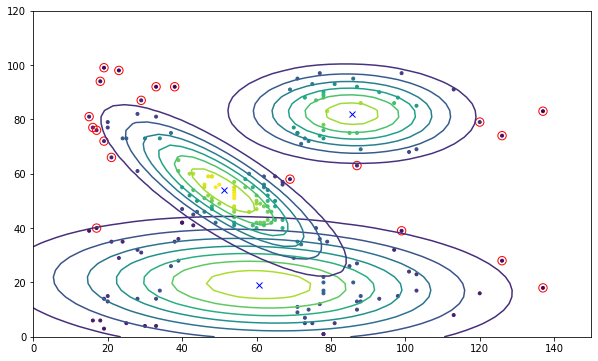

success!


In [21]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3: Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [42]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [43]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [44]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [45]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [46]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


Now let's convert the categorical columns to numeric. Give some thought as to whether it's appropriate
to do so for all of the columns.

In [47]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [48]:
Mu = np.mean(data[numerical_colmns])
Sigma = np.std(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64
Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64


In [49]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma*3
    return outlier.sum()

cnt_outlier(data, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

TotalSum     55
UnitPrice    20
Quantity      8
dtype: int64

In [50]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [51]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

data = data[~((data < Q1)) | (data > (Q3)).any(axis=1)]

In [52]:
data.dropna(inplace=True)
data

,StockCode,Quantity,InvoiceDate,UnitPrice,Country,TotalSum
249,193.0,4.0,0.0,5.95,0.0,23.80
252,195.0,8.0,0.0,9.95,0.0,79.60
255,197.0,96.0,0.0,1.85,0.0,177.60
256,198.0,96.0,0.0,1.85,0.0,177.60
259,199.0,12.0,0.0,3.75,0.0,45.00
...,...,...,...,...,...,...
4972,1043.0,1.0,2.0,3.75,0.0,3.75
4974,797.0,1.0,2.0,5.95,0.0,5.95
4976,862.0,1.0,2.0,7.95,0.0,7.95
4993,304.0,12.0,2.0,2.10,33.0,25.20


In [53]:
X = data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)


[[-1.31897143 -0.29950106 -1.13419693  0.20045584 -0.26689993 -0.07128888]
 [-1.31327591 -0.1210918  -1.13419693  0.69843629 -0.26689993  0.67518019]
 [-1.30758039  3.80391174 -1.13419693 -0.30997411 -0.26689993  1.98618321]
 ...
 [ 0.58618045 -0.43330799  1.4508509   0.44944606 -0.26689993 -0.28332355]
 [-1.00286999  0.05731745  1.4508509  -0.27885033  6.07069031 -0.05256027]
 [ 1.01904007 -0.38870568  1.4508509   0.69843629  6.07069031 -0.12346145]]


In [54]:
values = np.sum(np.abs(X) > 5, axis=1)
#index of values where sD is less than or equal to 5
indices = np.where(values == 0)[0]


In [55]:
X = X[indices,:]
print(X.shape)

(1744, 6)


In [56]:
X_new = X[:,[0,4]]

In [57]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster secific W for each dimension
        Wj = np.tile(W[:,j],(n,1)).T    
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [58]:
k = 3
Phi, Mu, Sigma = init_gmm(X_new, k)
threshold = threshold = np.matrix(.1)
converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)

In [59]:
print(Mu.shape)
m_distance = np.zeros((X_new.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X_new):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.05  
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)

(2, 3)


(1744, 6)
outlier (array([ 318,  319,  320,  321,  322,  323,  324,  325,  326,  327,  364,
        365,  366,  367,  368,  369,  370,  371,  372,  373,  374,  375,
        376,  377,  378,  379,  380,  381,  382,  383,  384,  385,  386,
        387,  388,  389,  390,  391,  392,  393,  394,  445,  446,  447,
        448,  449,  450,  451,  452,  453,  454,  455,  456,  457, 1205,
       1287, 1288, 1289, 1398, 1399, 1400, 1417, 1418, 1419, 1420, 1421,
       1422, 1423, 1424, 1425, 1461, 1462, 1463, 1464, 1595, 1596, 1597,
       1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608,
       1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619,
       1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630,
       1631, 1632, 1633, 1634, 1635, 1660, 1661, 1662, 1663, 1664]),)


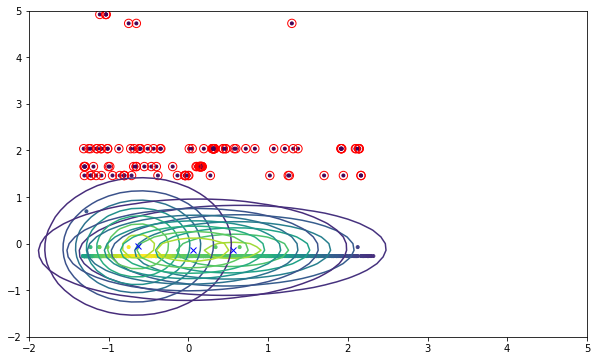

success!


In [60]:
print(X.shape)
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X_new[:,0],X_new[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X_new[outlier,0],X_new[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X_new[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(-2, 5, 50)
    ylist = np.linspace(-2, 5, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

In [95]:
def cost(X_label, Mu):
    loss = np.inf
    for j in range(Mu.shape[1]) : 
        Muj = Mu.T[j]
        Xj = X_label[X_label[:, -1] == j][:, :-1]
        loss = min(loss, np.min(np.linalg.norm(Xj-Muj, ord=2)))
    return loss

loss_log = []
for k in range(1,6):
    threshold = np.matrix(.1)

    Phi, Mu, Sigma = init_gmm(X_new, k)

    converged = False
    while not converged:
        converged, pj, X_label = iterate_em_gmm(X_new, threshold, Phi, Mu, Sigma)
    loss = cost(X_label, Mu)
    loss_log.append(loss)

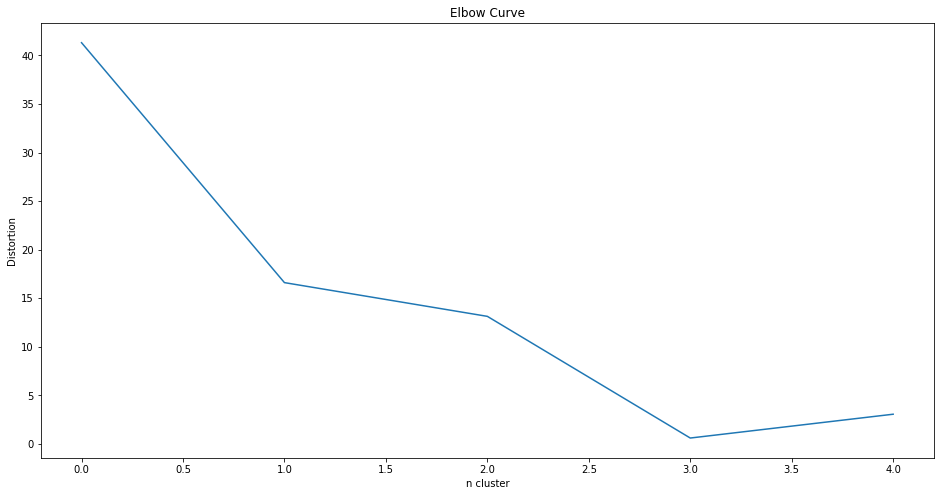

In [97]:
loss_log = np.array(loss_log)
plt.figure(figsize=(16,8))
plt.plot(loss_log)
plt.xlabel('n cluster')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

In the take home exercise GMM model was used for clustering. Mahalanobis distance was calculated to find the outliers/inliers and it was plotted. 
Same model was used for different values of k and loss was calculated. The loss curve plotted was as shown above. Using the elbow method it seems this dataset should be divided into 3 clusters.